# **Handling and Aggregating Sensing Data**

The following workflow attempts to analyze and model the relationships between mental health, academic performance, and cell phone sensing data for sixty Dartmouth students taken from a [public dataset](https://studentlife.cs.dartmouth.edu/dataset.html) made available on the website Dartmouth's Department of Comupter Science.

The primary goal is to see if I can, as was the intention of the original study, predict students' GPA scores from a combination of cell phone sensing data with other data sources like survey responses, or from cell phone sensing data alone. I will also see if it's possible to predict mental health outcomes. Finally, I'll be open to whatever qualitative results we can generate simply through digging deeply into the sensing data, the GPS data in particular.

Due to length, I will split this workflow up into three separate notebooks, this, the first, taking a look at sensing data, the second taking a close look at EMA and mental health survey data, and the third and final notebook synthesizing the data, developing the primary predictive models, and developing a web application that will serve as a product for students predicting their end-of-semester GPA.

In [13]:
from zipfile import ZipFile
from IPython.display import FileLink, FileLinks
import os
from pprint import pprint

import pickle

import time
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
import statistics as stats
import numpy as np
from scipy.stats import mstats
import itertools
import scipy.stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import OLS

import dash
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

# 1. Loading and Cleaning Data

Here I am loading in data for the following sensing data:
1. GPS Location
2. Conversation
3. Light
4. Phone Lock

I am preferring GPS location to wifi location data because the phones can send GPS coordinates regardless of whether they are connected to wifi, so for the purposes of this project I will prefer GPS location. Conversation data will be used to approximate relations and connections among students, light to approximate sleep, and phone lock to approximate how much students spend significant periods of time not using their phones during the day.

Each category of sensing data is contained in a folder of CSVs where each CSV corresponds to one student. To funnel this data into one dataframe for each sensing type, I will zip these CSVs into one zip file, import it into the notebook, then load the CSVs into a dictionary of dataframes. Then I'll add a column to each dataframe indicating what student it's related to, and then concatenate all the dataframes together.

The other dataframes I'll be working with will be student-wise (one row per student) rather than many observations per student, so the end purpose to the feature engineering process in this notebook is to aggregate sensing data on a per-student basis and eventually produce one dataframe with all the sensing data.

In [14]:
def generate_df(path, file_type):

    zip_file = ZipFile(path)

    # Creating dictionary with each file in the zip file loaded into a
    # Pandas DataFrame as a value. Keys are the file names.
    if file_type == 'json':
        dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
               for text_file in zip_file.infolist()
               if (text_file.filename.endswith('.json') &
                   ~text_file.filename.startswith('_'))
              }
    if file_type == 'csv':
        dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
               for text_file in zip_file.infolist()
               if (text_file.filename.endswith('.csv') &
                   ~text_file.filename.startswith('_'))
              }

    # Adding a column to each dataframe that identifies the student id (each
    # dataframe represents one student)
    for df_key in dfs:
        df = dfs[df_key]
        df['uid'] = df_key

    # Concatening all dataframes from dictionary
    df = pd.concat([dfs[df] for df in dfs],
                   sort=False)
    return df

In [15]:
path = '/Users/kristiancanler/Documents/Data/dartmouth_dataset/dataset/sensing/gps/gps.zip'
gps = generate_df(path, 'csv')

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/sensing/conversation/conversation.zip'
convo = generate_df(path, 'csv')

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/sensing/phonelock/phone_lock.zip'
lock = generate_df(path, 'csv')

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/sensing/dark/dark.zip'
dark = generate_df(path, 'csv')

There's what appears to be a missing comma at the end of the header of the GPS csv. The effect is that the column names are mismatched to the columns and the time variable is treated as the index. To solve this, at least in the case of GPS (and potentially in others), I reset the index and relabel the columns. Finally I use string methods to clean the uid (student id) column so that its just the integer and not the whole file name.

In [16]:
try:
    # Resetting index away from the unix time column
    gps.reset_index(inplace=True)
    
    # Shifting column labels to correct for missing comma issue
    gps.columns = [
        'time', 'provider', 'network_type', 'accuracy', 'latitude', 'longitude',
        'altitude', 'bearing', 'speed', 'travelstate', 'null', 'uid'
    ]

    # Cleaning uid column unless it's already been cleaned
    gps.uid = gps.uid.str.split('gps_u').str.get(1).str.split('.csv').str.get(0).astype(int)


    # Reducing GPS features to time, uid, and id
    gps = gps[['uid', 'time', 'longitude', 'latitude']]
    gps.head()
    
    gps = gps.loc[:, ['uid', 'time', 'longitude', 'latitude']].copy()
except:
    pass

gps.head()

uid        time  longitude   latitude
0   45  1364410654 -72.287042  43.706605
1   45  1364411866 -72.287005  43.706598
2   45  1364852743 -72.287039  43.706614
3   45  1364853942 -72.287025  43.706603
4   45  1364854001 -72.286592  43.707150

In [17]:
# Let's check how many rows we have per student in gps
len(gps) / gps.uid.nunique()

4140.34693877551

In [18]:
try:
    # Dropping 'unnamed' and reordering columns
    convo.columns = convo.columns.str.strip().str.lower()
    convo = convo[['uid', 'start_timestamp', 'end_timestamp']]

    # Cleaning id column
    convo.uid = convo.uid.str.extract('(\d\d)').astype(int)
except:
    pass

convo.head()

uid  start_timestamp  end_timestamp
0   10       1364359361     1364359583
1   10       1364359814     1364359894
2   10       1364391152     1364391404
3   10       1364392106     1364392298
4   10       1364392558     1364393506

In [19]:
try:
    # Dropping 'unnamed' and reordering columns
    dark.columns = dark.columns.str.strip().str.lower()
    dark = dark[['uid', 'start', 'end']]

    # Cleaning id column
    dark.uid = dark.uid.str.extract('(\d\d)').astype(int)
except:
    pass
dark.head()

uid       start         end
0   53  1364416619  1364422369
1   53  1364435998  1364440390
2   53  1364489989  1364500799
3   53  1364500800  1364511755
4   53  1364511986  1364516418

In [20]:
try:
    # Cleaning id column
    lock.uid = lock.uid.str.extract('(\d\d)').astype(int)

    # Reordering columns
    lock = lock[['uid', 'start', 'end']]
except:
    pass
lock.head()

uid       start         end
0    9  1364354446  1364387635
1    9  1364401807  1364405921
2    9  1364410419  1364419879
3    9  1364420409  1364434137
4    9  1364441783  1364476678

In [21]:
try:
    # Cleaning id columns
    dark.uid = dark.uid.str.extract('(\d\d)').astype(int)
except:
    pass
dark.head()

uid       start         end
0   53  1364416619  1364422369
1   53  1364435998  1364440390
2   53  1364489989  1364500799
3   53  1364500800  1364511755
4   53  1364511986  1364516418

In [22]:
# Checking for nulls in each df
df_list = {'gps': gps,
           'convo': convo,
           'lock': lock,
           'dark': dark}

for df in df_list:
    nulls = df_list[df].isnull().sum().sum()
    null_ratio = nulls / df_list[df].size
    print('{:.4%} of values are missing in {}'
          .format(null_ratio, df))

0.0000% of values are missing in gps
0.0000% of values are missing in convo
0.0000% of values are missing in lock
0.0000% of values are missing in dark


# 2. GPS Location data

As a first step, let's map the latitude-longtiude (lat-lon) coordinates on regional and local maps.

## 2.1 Scatterplotting lat-lon data

In [23]:
# This function creates a smaller dataframe within a square
# bounded area specified with Lat-Lon coordinates
def create_box_df(latlon_box, df):
    box_df = df.loc[
        (df.longitude > latlon_box[0]) &
        (df.longitude < latlon_box[1]) &
        (df.latitude > latlon_box[2]) &
        (df.latitude < latlon_box[3]), 
    :].copy()
    
    return box_df

Below I've created two lat-lon boxes that define two areas, the region around Vermont including major cities that includes most of the gps coordinates, and a smaller box containing all the points around campus and Hanover.

In [24]:
# For regional area around Vermont including New York, etc
regional_box =(
    -75,  # Left Lon
    -70,  # Right Lon
    40,   # Bottom Lat
    46    # Top Lat
)

# Area directly around campus and Hanover
hanover_box =(
    -72.2985,  # Left Lon
    -72.2810,  # Right Lon
    43.6990,   # Bottom Lat
    43.7100    # Top Lat
)

# Calling the create_box_df function on the regional and local boxes
regional = create_box_df(regional_box, gps)
hanover = create_box_df(hanover_box, gps)

In [25]:
# Defining a function that plots all the coordinates
# from any given dataframe
def map_coordinates(box, image, df, dot_size, alpha):
    
    ratio = len(df) / len(gps)

    gps_map = plt.imread(image)

    fig, ax = plt.subplots(clear=True,
                           tight_layout=True,
                           dpi=1000)
    sns.scatterplot(x=df.longitude,
                    y=df.latitude,
                    s=dot_size)
    ax.set_xlim(box[0],
                box[1])
    ax.set_ylim(box[2],
                box[3])
    ax.imshow(gps_map, zorder=0, extent = box, aspect= 'equal')
    plt.legend([])
    plt.title('{:.0%} of Coordinates'.format(ratio))
    plt.show()

First we'll take a look at the the dataframe as a whole, or just about all of it. Then we'll look at the values around Hanover and campus.

The photos I'm using were pulled from the OpenStreetMap tool, which was able to get me the most sufficiently high resolution image in an efficient way. 

In [26]:
# path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/map_photos/regionalmap.png'

# map_coordinates(
#     regional_box,
#     path,
#     regional,
#     4,
#     .75)

About 17% of our coordinates lie outside of campus/hanover but within the region above. Here's a closer look at the spread of coordinates over the campus and hanover area. These are coordinates from all the students in the study, for all times of day, for any day in the 10 week period.

In [27]:
# path = '/Users/kristiancanler/Desktop/openstreetmap2.png'

# map_coordinates(
#     hanover_box,
#     path,
#     hanover,
#     ,
#     .5
# )

## 2.2 Timeblocking

The first thing we'll want to do is to get a feel for how this data changes over the course of the day. First we'll create a new feature representing datetime dervied from unix time, from which we can determine the hour of day any one of the given coordinates was registered.

Then we'll create four time brackets for the morning, the afternoon, the evening, nighttime, and then a late night / early morning period, from 3am to 6am, where we'l assume the majority of students are staying either in their residence or another place where they sometimes spend the night. We'll create a visualization giving a general look at the structure of that data, then zoom in on that last variable and create an unsupervised machine learning model to distinguish between the various residences. We'll then continue the same unsupervised analysis for daytime and evening to get a feel for how each student typically moves from place to place over the course of the average day.

In [28]:
# Creating datetime feature
hanover['datetime'] = pd.to_datetime(hanover.time, origin='unix', unit='s')

# Creating timeblock categorical variable
hanover['timeblock'] = np.nan

timeblock_dict = {
    'overnight': [3, 6],
    'morning': [6, 12],
    'afternoon': [12, 17],
    'evening': [17, 20],
    'night': [20, 24],
    # night requires two entries to deal with 24/0 gap
    'night': [0, 3]
}

for timeblock in timeblock_dict:
    hanover.loc[
        (hanover.datetime.dt.hour >= timeblock_dict[timeblock][0]) &
        (hanover.datetime.dt.hour < timeblock_dict[timeblock][1]),
        'timeblock'
    ] = timeblock

Using this feature engineering method has left out a considerable number of observations, represented with NaN in the `timeblock` feature. I'll use a Seaborn countplot to visualize when these missing observations are occurring.

17.8% of elements in hanover.timeblock are missing


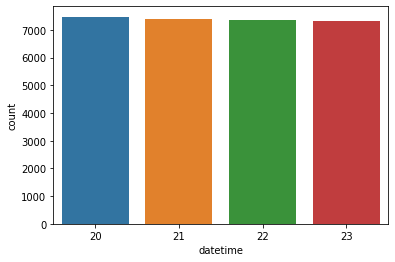

In [29]:
ratio_null = hanover.timeblock.isnull().sum() / len(hanover)
print('{:.1%} of elements in hanover.timeblock are missing'
      .format(ratio_null))

sns.countplot(
    hanover.loc[
        hanover.timeblock.isnull(),
        'datetime'
    ].dt.hour
)

Since all the missing values are in hours within the limits of the value for the first key `night`, I think its safe to say that the for loop applied to `timeblock_dict` is only picking out the second `night` key. We can check this by printing the `timeblock_dict` keys:

In [30]:
timeblock_dict.keys()

dict_keys(['overnight', 'morning', 'afternoon', 'evening', 'night'])

So from this we learn that dictionary keys have to be unique in order to work properly. In this case, we can simply use `.fillna` to fill all the missing values with "night". To not run into this problem again in the future it would be necessary to create two keys for "night" and then reset the corresponding values in `hanover.timeblock` to the string "night" manually, or to use a different methodology other than a dictionary to create the new feature.

In [31]:
hanover.timeblock.fillna(
    value='night',
    inplace=True
)

if hanover.timeblock.isnull().sum() == 0:
    print('No missing remaining.')

No missing remaining.


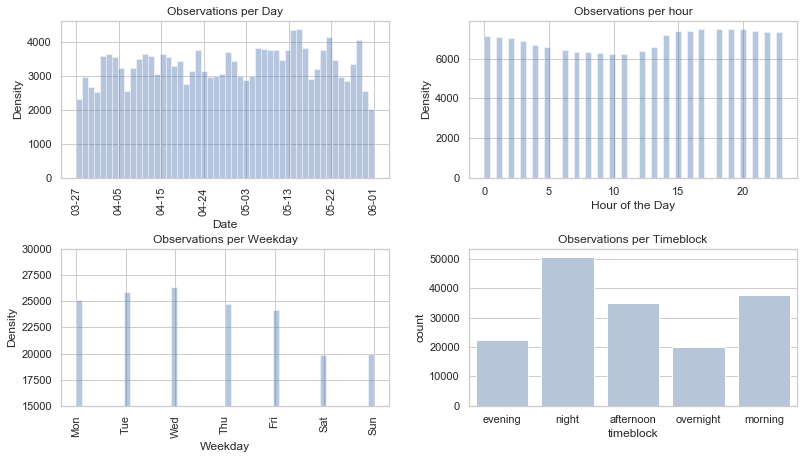

In [32]:
sns.set(style='whitegrid')

# Getting a look at the spread of gps time data
# over the course of the study
fig, ax = plt.subplots(nrows=2, ncols=2,
                       figsize=(12,7))
fig.tight_layout(pad=4)

plt.subplot(221)
dplot = sns.distplot(
    hanover.time,
    kde=False
)

xticks = pd.Series([
    hanover.time.min() + (
        (hanover.time.max() - hanover.time.min()) / 7 * (i)
    )
     for i in list(range(8))
])

xtick_dates = pd.to_datetime(xticks, unit='s').dt.strftime('%m-%d')

dplot.set_xticks(xticks)
dplot.set_xticklabels(xtick_dates,
                      rotation=90)
plt.xlabel('Date')
plt.ylabel('Density')
plt.title('Observations per Day')

plt.subplot(222)
dplot2 = sns.distplot(
    hanover.datetime.dt.hour,
    kde=False
)
plt.xlabel('Hour of the Day')
plt.ylabel('Density')
plt.title('Observations per hour')

plt.subplot(223)

dplot3 = sns.distplot(
    hanover.datetime.dt.weekday,
    kde=False
)
dplot3.set_xticks(list(range(7)))
dplot3.set_xticklabels(
    ['Mon', 'Tue', 'Wed', 'Thu',
     'Fri', 'Sat', 'Sun'],
    rotation=90
)
plt.xlabel('Weekday')
plt.ylabel('Density')
plt.ylim([15000, 30000])
plt.title('Observations per Weekday')

plt.subplot(224)
dplot4 = sns.countplot(
    hanover.timeblock,
    color='lightsteelblue'
)
plt.title('Observations per Timeblock')

plt.show()

Now we'll compare the timeblocks visually in terms of the geographical spread of observations.

In [33]:
# Defining function to scatterplot timeblocks alongside each other
def compare_timeblocks(timeblock1, timeblock2):

    gps_map = plt.imread('/Users/kristiancanler/Desktop/openstreetmap2.png')
    
    timeblock1_df = hanover[hanover.timeblock == timeblock1]
    timeblock2_df = hanover[hanover.timeblock == timeblock2]

    fig, ax = plt.subplots(clear=True,
                           tight_layout=True,
                           figsize=(15,8))
                            
    plt.subplot(121)
    ax1 = sns.scatterplot(x=timeblock1_df.longitude,
                            y=timeblock1_df.latitude,
                            s=5,
                            alpha=.75,
                            markers='o',
                            color='darkred')
    ax1.set_xlim(hanover_box[0],
                hanover_box[1])
    ax1.set_ylim(hanover_box[2],
                hanover_box[3])
    ax1.imshow(gps_map, zorder=0, extent = hanover_box, aspect= 'equal')
    plt.title(timeblock1+' {:.0%} of Coordinates'.format(len(timeblock1_df) / len(gps)))

    
    plt.subplot(122)
    ax2 = sns.scatterplot(x=timeblock2_df.longitude,
                    y=timeblock2_df.latitude,
                    s=5,
                    alpha=.75,
                    markers='o',
                    color='darkred')
    ax2.set_xlim(hanover_box[0],
                hanover_box[1])
    ax2.set_ylim(hanover_box[2],
                hanover_box[3])
    ax2.imshow(gps_map, zorder=0, extent = hanover_box, aspect= 'equal')
    plt.title(timeblock2+':  {:.0%} of Coordinates'.format(len(timeblock2_df) / len(gps)))
    plt.show()

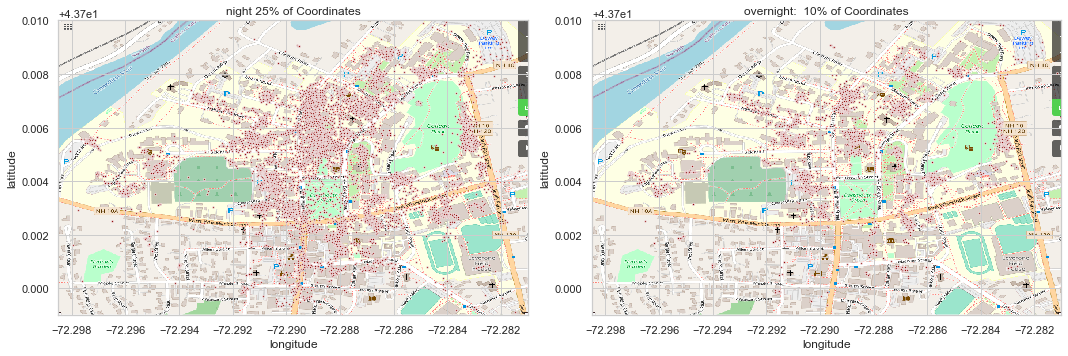

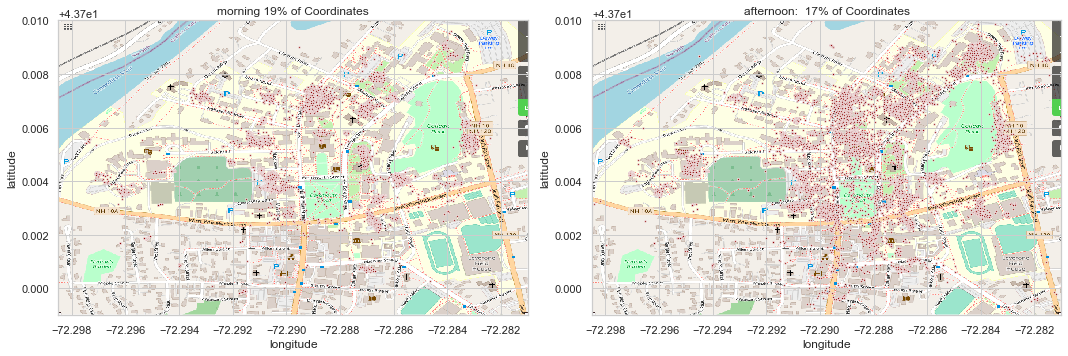

In [34]:
compare_timeblocks('night', 'overnight')
compare_timeblocks('morning', 'afternoon')

Between 'night' and 'overnight' we see a strong restriction in the distribution of observations. This would justify an approach using an algorithm to cluster students during this early morning period, where they seem to be strongly concentrated in the place where they're spending the night. In the morning we're still seeing strong concentration, if with fewer students in the library*, but after noon the observations spread out again.

*There's a strong concentration of students in the library and in the computer science department between 3am and 6am. Once we've identified these clusters using an algorithm we can identify exactly how many observations or discerete students are using the department in the library in this early morning period, and how department and library use look throughout the day.

## 2.3 Clustering Overnight GPS Coordinates

Based on the research I've done so far, it looks like not standardizing lat-lon and unix time data is better for accurate clustering. I will also need to identify the cluster locations with lat-lon averages after the unsupervised modeling, and leaving the data as-is will speed that process.

In [35]:
# Loading overnight GPS data into X
X = hanover.loc[
    hanover.timeblock=='overnight',
    ['latitude', 'longitude', 'time']
]

Here we're looking for the highest number of clusters that still gives us a maximal or close to maximal silhouette score. Since we don't have any 'true' values for our clusters, we won't be using a supervised-style metric like Adjusted Rand Index. Using an unsupervised model in this case is in a sense qualitative, or a step in feature engineering, or could be understood simply as a more rapid method of mapping the lat-lon data onto campus locations.

I also took the time to box out all the major campus locations in addition to doing this clustering work, but found that the clustering methodology actually provided more helpful information because many coordinates are recorded just outside of the lat-lon coordinate box of a given building, but clearly belong to the cluster of students using that space. It also helps concentrate attention on where students actually are in relation to shared space rather than introducing information from outside of the data in the form of lat-lon boxes.

In [36]:
# A function that creates a line plot for a set of values for k
# and the corresponding silhouette scores
def visualize_silhouette(k_vals, silhouette_scores):
    sns.set(style='whitegrid')
    lplot = sns.lineplot(k_vals, silhouette_scores, label='Silhouette score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Silhouette for K 10–35')
    lplot.set_xticks(k_vals)
    lplot.set_xticklabels(k_vals)
    plt.legend()
    plt.show()

### 2.3.1 K-Means

I'm ranging the number of possible clusters from 10 to 65 because it's visually clear that there are at least ten major clusters, and it's unlikely that there are more than 100 distinct buildings differentiated in a meaningful way in the area in which observations are concentrated.

In [37]:
%%time
# First search, between 10 & 100, with 15 iterations
params = {'n_clusters': list(range(10, 100))}
rsearch = RandomizedSearchCV(
    KMeans(random_state=42),
    params,
    cv=5,
    n_iter=15
).fit(X)
print(rsearch.best_estimator_)

KeyboardInterrupt: 

In [38]:
%%time
k_vals = list(range(40, 100, 5))
silhouette_scores = []

for k in k_vals:
  kmeanslabels = KMeans(n_clusters=k, random_state=42).fit_predict(X)
  silhouette_score = metrics.silhouette_score(X, kmeanslabels, metric='euclidean')
  silhouette_scores.append(silhouette_score)

KeyboardInterrupt: 

In [39]:
plt.figure(figsize=(15,4))
visualize_silhouette(k_vals, silhouette_scores)
plt.show()

ValueError: arrays must all be same length

<Figure size 1080x288 with 0 Axes>

The Randomized Search CV from scikit-learn selects the best value of k by minimizing the sum of distances of observations from cluster centroids, in this case without a cap on iterations or a minimum change criterion is met. The second figure just assesses values of k between 40 and 95 for their silhouette scores. 65 is just at or above the upper limit of what would make sense geographically, and the scoring from cross validation indicates a much larger value for k would be preferable.

From this I noticed that I accidentally created clusters in a *three dimensional* space, with longitude, latitude, *and time*, creating a much, much larger space in which for clusters to be found, with way fewer observations per cluster. This method would be seeking to find groups of students *as they appeared in real time*, as opposed to tendencies for students to congregate in certain areas *over the course of the study*. With that correction, that's what we'll turn to next, modifying X, and taking silhouette scores as our metric for choosing a value for k.

In [40]:
# Loading overnight GPS data into X
X = hanover.loc[
    hanover.timeblock=='overnight',
    ['latitude', 'longitude']
]

In [ ]:
%%time
k_vals = list(range(30, 100, 5))
silhouette_scores = []

for k in k_vals:
  kmeanslabels = KMeans(n_clusters=k, random_state=42).fit_predict(X)
  silhouette_score = metrics.silhouette_score(X, kmeanslabels, metric='euclidean')
  silhouette_scores.append(silhouette_score)

In [ ]:
plt.figure(figsize=(15,4))
visualize_silhouette(k_vals, silhouette_scores)
plt.show()

In [41]:
%%time
# Repeating in a smaller range to find exact k
k_vals = list(range(44, 51))
silhouette_scores = []

for k in k_vals:
  kmeanslabels = KMeans(n_clusters=k, random_state=42).fit_predict(X)
  silhouette_score = metrics.silhouette_score(X, kmeanslabels, metric='euclidean')
  silhouette_scores.append(silhouette_score)

CPU times: user 1min 44s, sys: 1min 20s, total: 3min 5s
Wall time: 3min 28s


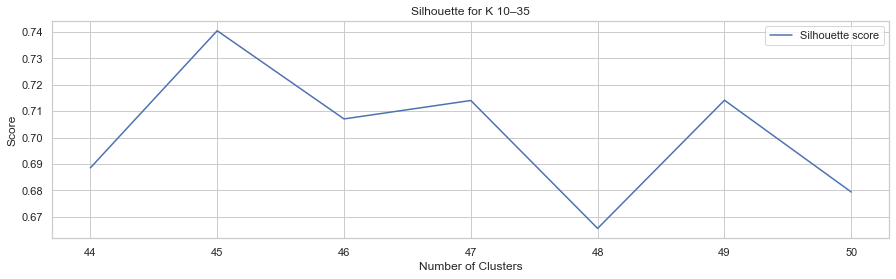

In [42]:
plt.figure(figsize=(15,4))
visualize_silhouette(k_vals, silhouette_scores)
plt.show()

I'm selecting 49 as the value of k because the purpose here is to be identify as many discrete locations/clusters of observations as possible (for maximum specificity) without sacrificing consistency.

In [43]:
hanover.loc[
    hanover.timeblock == 'overnight',
    'kmeans_labels'
] = KMeans(n_clusters=49, random_state=42
          ).fit_predict(X)

In [44]:
# This function generates a map with all the lat-lon coordinates, but
# where each cluster has a different color
def map_clusters(df, labels):

    gps_map = plt.imread('/Users/kristiancanler/Desktop/openstreetmap2.png')

    fig, ax = plt.subplots(clear=True,
                           tight_layout=True,
                           dpi=1000)
    sns.scatterplot(x=df.longitude,
                    y=df.latitude,
                    hue=df[labels],
                    palette=sns.color_palette("hls", df[labels].nunique()),
                    s=3)
    ax.set_xlim(hanover_box[0],
                hanover_box[1])
    ax.set_ylim(hanover_box[2],
                hanover_box[3])
    ax.imshow(gps_map, zorder=0, extent = hanover_box, aspect= 'equal')
    plt.legend([])
    plt.show()

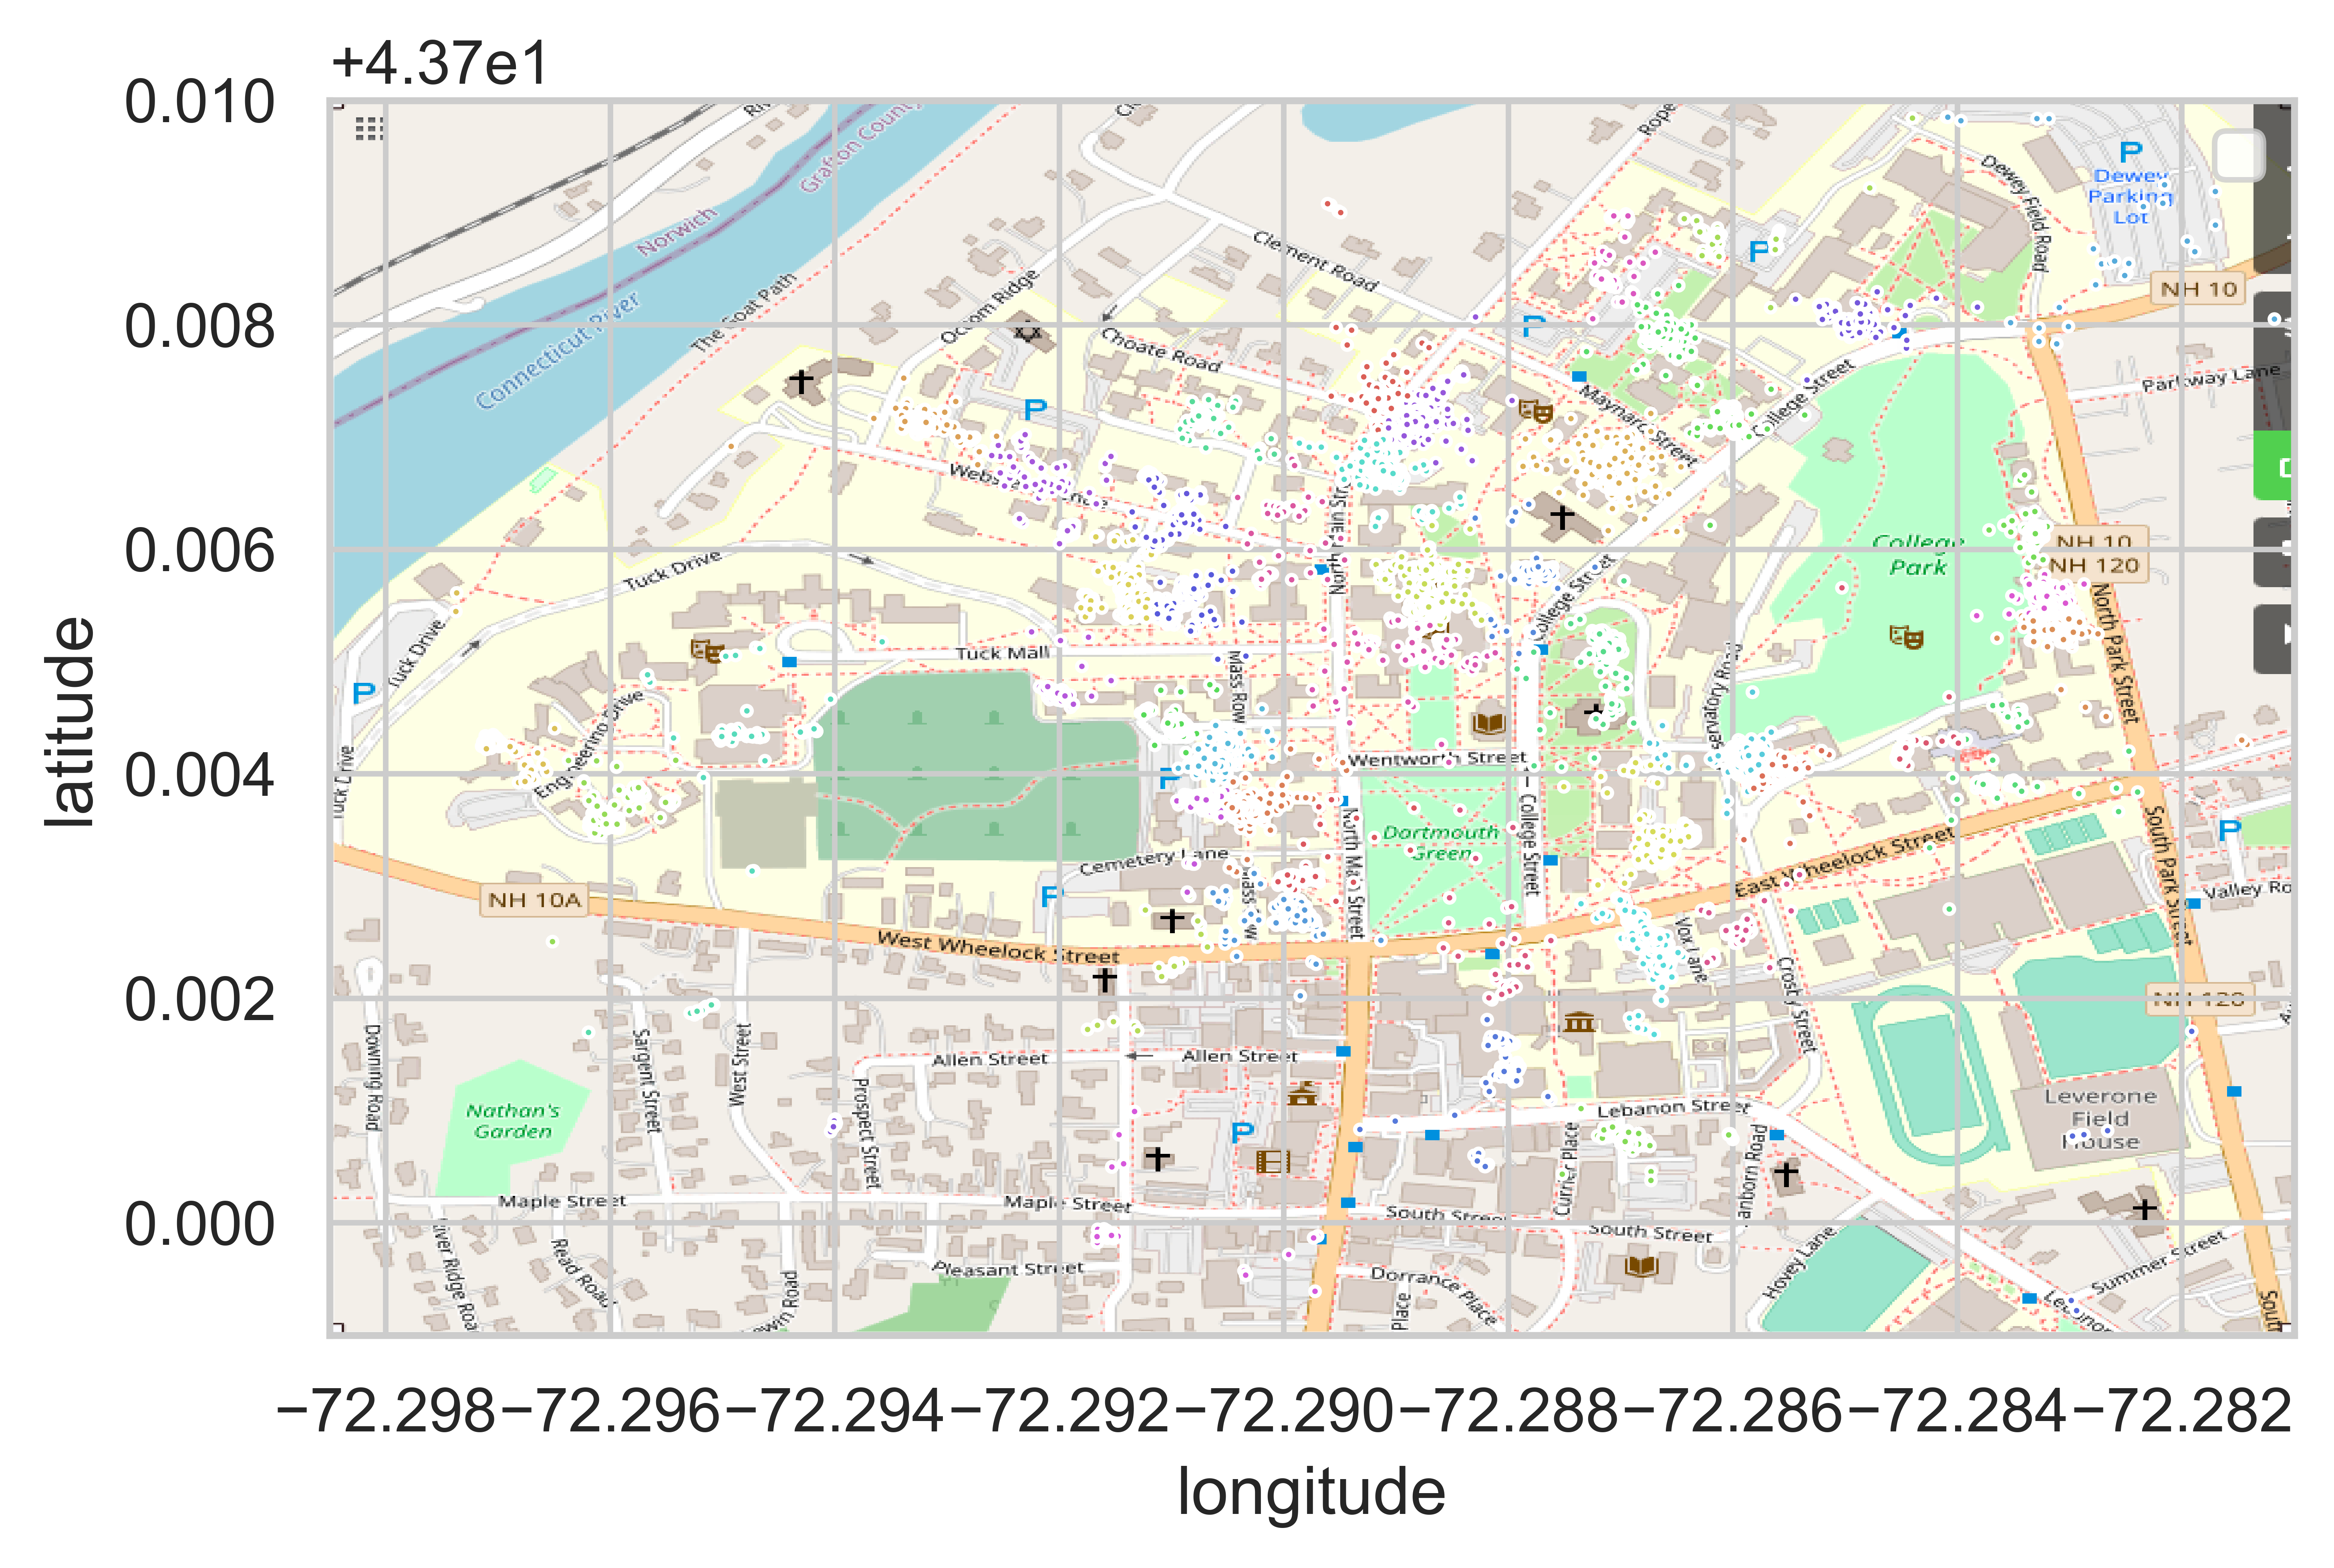

In [45]:
overnight = hanover.loc[
    hanover.timeblock == 'overnight',
    :]

map_clusters(overnight, 'kmeans_labels')

An iteration in a previous notebook with `k=47` failed to separate a greek house and the Native American house, as well as part of the North Park Apartments and Triangle House, but once `k=49`, the algorithm is able to split these clusters. (In the previous iteration they had to be split manually with lat-lon boxes.)

### 2.3.2 Comparing K-Means with Other Models

K-Means is our best performing model, but I want to also show other models I've run and how they compare with K-Means, specifically DBSCAN and Gaussian Mixture modeling.

#### **EXPLAIN THIS**

In [ ]:
nbrs = NearestNeighbors(n_neighbors=2)
nbrs.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(15,5))
plt.plot(distances)
plt.xlim([20000, 20150])

Our point of greatest curvatures is `0.00045`, so I'll use that as the value for epsilon in DBSCAN.

In [ ]:
%%time
scores = []
for min_sample in list(range(2,10)):
    dbscan_labels = DBSCAN(min_samples=min_sample, eps=.00045).fit_predict(X)
    score = metrics.silhouette_score(X, dbscan_labels)
    scores.append(score)

In [ ]:
plt.figure(figsize=(15,4))
visualize_silhouette(list(range(2,10)), scores)

In [ ]:
%%time
scores = []
for min_sample in list(range(10,20,3)):
    dbscan_labels = DBSCAN(min_samples=min_sample, eps=.00045).fit_predict(X)
    score = metrics.silhouette_score(X, dbscan_labels)
    scores.append(score)

In [ ]:
plt.figure(figsize=(15,4))
visualize_silhouette(list(range(10,20,3)), scores)

In [ ]:
hanover.loc[
    hanover.timeblock == 'overnight',
    'dbscan_labels'
] = DBSCAN(min_samples=13, eps=.00045).fit_predict(X)
print(hanover.dbscan_labels.nunique())

In [ ]:
overnight = hanover.loc[
    hanover.timeblock == 'overnight',
    :]

map_clusters(overnight, 'dbscan_labels')

With this set of lat-lon data, DBSCAN isn't able to identify as many clusters as K-Means is.

## 2.4 Gathering Information about Overnight Clusters

In [49]:
# Pulling Lat-Lon coordinate of the mean of each cluster
mean_latlon_dict = {}
for cluster in np.sort(overnight.kmeans_labels.unique()): 
    lat_mean = stats.mean(overnight.loc[overnight.kmeans_labels==cluster, 'latitude'])
    lon_mean = stats.mean(overnight.loc[overnight.kmeans_labels==cluster, 'longitude'])
    
    mean_latlon_dict[cluster] = [lat_mean, lon_mean]

In [50]:
for cluster in mean_latlon_dict:      # Use for loop to select which coordinates to print
    print(cluster, mean_latlon_dict[cluster])

0.0 [43.70736658781916, -72.28910161207173]
1.0 [43.704018254578756, -72.28556620787546]
2.0 [43.70368747598916, -72.29032971094851]
3.0 [43.705339360800885, -72.28316655611316]
4.0 [43.707120216366995, -72.29321873549262]
5.0 [43.706667229276356, -72.28705689101581]
6.0 [43.70427154907217, -72.29701145092784]
7.0 [43.70565647050467, -72.29136252446729]
8.0 [43.703366555641026, -72.28659596951049]
9.0 [43.70564435276392, -72.28868891986565]
10.0 [43.702174013793105, -72.2911735551724]
11.0 [43.708752419285716, -72.28576974142857]
12.0 [43.70363035489362, -72.29599814340426]
13.0 [43.70074440387755, -72.28681563061224]
14.0 [43.706148774099375, -72.28330529918013]
15.0 [43.70711618573991, -72.28600058190582]
16.0 [43.704411511089354, -72.29095114680538]
17.0 [43.70790260218254, -72.2866212213623]
18.0 [43.70392634802508, -72.28366659103449]
19.0 [43.70505849850515, -72.2871385791237]
20.0 [43.70717221725111, -72.29071124912036]
21.0 [43.701877329577464, -72.29528930422535]
22.0 [43.7043

In the dictionary below, each cluster is paired with the name of the cluster's location, tracked by plugging the mean lat-lon coordinates into Google Maps. Without using GIS software I've obviously had to do this manually, which works due to the size of the dataset and my familarity with Dartmouth's campus. In some cases, these are particular buildings. In other cases, I've generalized slightly to include the house the building or hall is a part of, the department or school it's a part of, or if it's a part of a cluster of Greek buildings on Webster Ave. In the dictionary below, I've simply entered the type of building the structure is, whether living learning community, or academic hall, etc.

In [51]:
locations_dict = {
    0: 'living_learning',
    1: 'house',
    2: 'house',
    3: 'apartments',
    4: 'greek',
    5: 'cs_dept',
    6: 'firstyear',
    7: 'house',
    8: 'firstyear',
    9: 'library',
    10: 'greek',
    11: 'academic',
    12: 'apartments',
    13: 'house',
    14: 'apartments',
    15: 'living_learning',
    16: 'house',
    17: 'living_learning',
    18: 'house',
    19: 'firstyear',
    20: 'firstyear',
    21: 'off_campus',
    22: 'academic',
    23: 'greek',
    24: 'house',
    25: 'house',
    26: 'house',
    27: 'off_campus',
    28: 'commons',
    29: 'greek',
    30: 'academic',
    31: 'off_campus',
    32: 'house',
    33: 'greek',
    34: 'academic',
    35: 'off_campus',
    36: 'living_learning',
    37: 'greek',
    38: 'house',
    39: 'house',
    40: 'off_campus',
    41: 'apartments',
    42: 'academic',
    43: 'library',
    44: 'greek',
    45: 'house',
    46: 'commons',
    47: 'house',
    48: 'commons'
}

In [52]:
# Using dictionary to fill values by row. .apply()
# may be worth considering as more effecient method
for cluster in locations_dict:
    hanover.loc[
        (hanover.timeblock=='overnight') &
        (hanover.kmeans_labels==cluster),
        'cluster_type'
    ] = locations_dict[cluster]

In [53]:
# Checking to make sure no rows were left out
hanover[hanover.timeblock=='overnight'].cluster_type.isnull().sum()

0

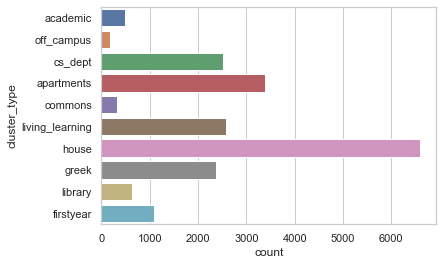

In [54]:
sns.countplot(
    y=hanover.loc[
        hanover.timeblock=='overnight',
        'cluster_type'
    ]
)

As we can see, many students live in the residential houses, but the majority of students don't (or are spending the majority of their time between 3am and 6am outside of them). It was also a good decision to split academic locations from the computer science department location specifically, since there are far more students in the computer science department overnight than in other academic locations. This is what led me to check if all the students are computer science students originally.

I think it's worth checking why students are in the computer science department late at night so much. Let's check to see if this peaks before midterms and exams.

In [55]:
sorted_dates = [date for date in
               np.sort(hanover.datetime.dt.date.unique().tolist())]

date_cs_counts = [
    len(hanover[
            (hanover.timeblock=='overnight') &
            (hanover.datetime.dt.date == date) &
            (hanover.cluster_type == 'cs_dept')
    ]) for date in sorted_dates]

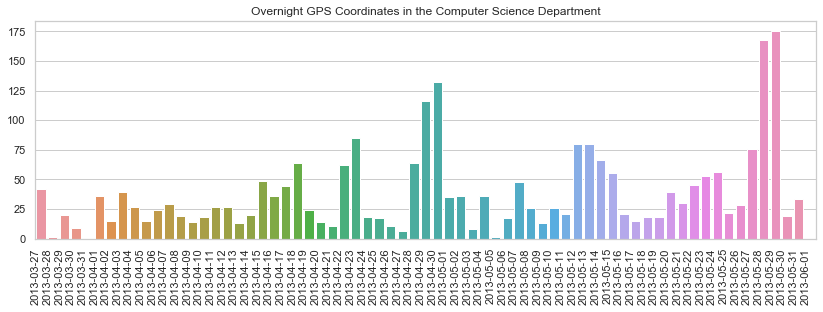

In [56]:
plt.figure(figsize=(14, 4))
bplot = sns.barplot(
    x=sorted_dates,
    y=date_cs_counts
)
bplot.set_xticklabels(sorted_dates, rotation = 90, ha="right")
plt.title('Overnight GPS Coordinates in the Computer Science Department')
plt.show()

So we can confirm these spikes around midterms in late april and again for exams in late may. Now let's see if there are any changes to presence in greek houses over the course of an average week.

In [57]:
sorted_weekdays = [date for date in
               np.sort(hanover.datetime.dt.weekday.unique().tolist())]

weekday_greek_counts = [
    len(hanover[
            (hanover.timeblock=='overnight') &
            (hanover.datetime.dt.weekday == weekday) &
            (hanover.cluster_type == 'greek')
    ]) for weekday in sorted_weekdays]

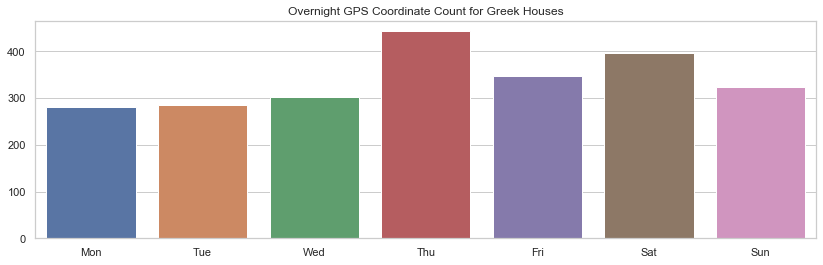

In [59]:
plt.figure(figsize=(14, 4))
bplot = sns.barplot(
    x=sorted_weekdays,
    y=weekday_greek_counts
)
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
bplot.set_xticklabels(weekday_names)
plt.title('Overnight GPS Coordinate Count for Greek Houses')
plt.show()

So we're seeing spikes early Thursday morning (after a Wednesday night) and early Saturday morning (after a Friday night), which corresponds to observations from the original study on this data that there tend to be Greek parties on Wednesday night because classes start late on Thursday mornings. It's notable that Wednesday night is actually a bigger night for this than Friday, and that even within the 3am-6am block, there are still many more students (exact percentage calculated below) still partying or staying over in Greek houses than average.

In [60]:
thu_overnight = len(hanover[
    (hanover.timeblock=='overnight') &
    (hanover.cluster_type == 'greek') &
    (hanover.datetime.dt.weekday==3)])

avg_overnight = len(hanover[(hanover.timeblock=='overnight') &
        (hanover.cluster_type == 'greek')]) / 7
diff = thu_overnight / avg_overnight - 1
print('On Thursdays there are {:.1%} more students in Greek houses than average.'
      .format(diff))

On Thursdays there are 30.4% more students in Greek houses than average.


In [61]:
hanover.cluster_type.unique()

array([nan, 'academic', 'off_campus', 'cs_dept', 'apartments', 'commons',
       'living_learning', 'house', 'greek', 'library', 'firstyear'],
      dtype=object)

## 2.5 Creating Aggregates

Now we'll create an aggregated, student-wise dataframe that has cluster information for each student. There will be a feature for each type of cluster, and how many observations are recorded for each student associated with that cluster. Finally, there will be a categorical variable labelling the student with their primary location, intended to identify whether or not the student is greek, firstyear, or a graduate student (most of the 'apartments' are for graduate students).

In [78]:
sensing = pd.DataFrame(columns=['uid', 'academic', 'off_campus', 'cs_dept', 'apartments',
                                'commons', 'living_learning', 'house', 'greek', 'library',
                                'firstyear', 'primary'])
sensing.uid = list(hanover.uid.unique())

In [79]:
%%time
# .apply outperforms itertools in this case. 
for var in hanover.cluster_type.unique():
    sensing[var] = sensing.uid.apply(lambda uid:
                                len(hanover[(hanover.uid==uid)&
                                            (hanover.timeblock=='overnight')&
                                            (hanover.cluster_type==var)]))

CPU times: user 11.6 s, sys: 456 ms, total: 12 s
Wall time: 12.2 s


In [80]:
sensing.primary = sensing.uid.apply(
    lambda uid: locations_dict[
        hanover.loc[
            (hanover.uid==uid)&
            (hanover.timeblock=='overnight'),
            'kmeans_labels'
        ].value_counts(ascending=False)
         .reset_index()
         .iloc[0,0]
    ]
)

In [81]:
cs_dept_ids = sensing.loc[
    sensing.primary=='cs_dept',
    'uid'
]

outside_hanover = 1 - len(hanover) / len(gps)

cs_outside_hanover = (1 - len(hanover[hanover.uid.isin(cs_dept_ids)]) /
                      len(gps[gps.uid.isin(cs_dept_ids)]))

cs_num_observations = sensing.loc[
    sensing.primary == 'cs_dept',
    'cs_dept'
].mean()

avg_num_observations = sensing.cs_dept.mean()

print('{:.1%} of observations are outside the hanover area in the GPS dataframe as a whole,'
      .format(outside_hanover)+
      ' but {:.1%} of observations are outside hanover for students whose primary location'
      .format(cs_outside_hanover)+
      ' is the comupter science department. Additionally, these students average {}'
      .format(round(cs_num_observations))+
      ' observations in the computer science department, but the average is {}.'
      .format(round(avg_num_observations))
     )

18.1% of observations are outside the hanover area in the GPS dataframe as a whole, but 56.1% of observations are outside hanover for students whose primary location is the comupter science department. Additionally, these students average 147 observations in the computer science department, but the average is 51.


Based on this we can conclude the students whose primary location is the computer science department live outside Hanover, and that is this probably the reason why they spend more time in the department (they don't have a dorm on campus to study in).

In [84]:
sns.barplot(
    x=sensing.primary,
    y=sensing.gpa_13s.groupby('primary').sum()
)

AttributeError: 'DataFrame' object has no attribute 'gpa_13s'

## 2.6 Final Comments on GPS Data

In other notebooks I've also clustered data for the morning and afternoon timeblock, but we'll set aside that information for now on the assumption that overnight data will be sufficiently predictive for GPA and mental health outcomes.

# 3. Conversation Proximity Data

This dataset contains information about when each student was near a conversation. In addition to some metrics aggregated per student, I'll also create features based on K-Means clustering as with the GPS location data.

First let's see if there's any general trajectory over the course of the study.

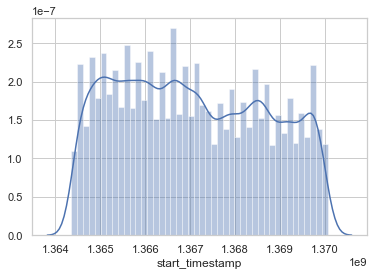

In [43]:
# Num convos over period
sns.distplot(convo.start_timestamp)

We do see a general downward trend over the course of the semester. Let's see if the duration of those conversations is changing, as well. First we'll have to create a new feature of the length of each conversation in seconds.

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


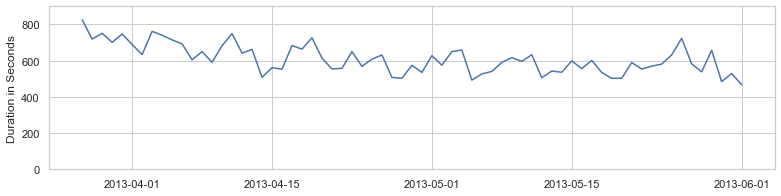

In [69]:
# Creating duration feature
convo['duration'] = convo.end_timestamp - convo.start_timestamp
# Creating datetime feature based on start_timestamp
convo['datetime'] = pd.to_datetime(convo.start_timestamp, unit='s') # Make sure to include unit

# Create sorted list of unique dates
dates = [date for date in np.sort(list(convo.datetime.dt.date.unique()))]

# Create dictionary of corresponding avg durations for each date
date_avg_duration = {date: convo.loc[convo.datetime.dt.date==date,
                               'duration'
                              ].mean()
                     for date in dates}

# Visualize change over time
plt.figure(figsize=(13,3))
sns.lineplot(
    x=list(date_avg_duration.keys()),
    y=list(date_avg_duration.values())
)
plt.ylim([0,900])
plt.ylabel('Duration in Seconds')
plt.show()

So we see a consistent downward trend in the length of conversations, as well, over the semseter, from over 13 minutes to about 7 minutes on average.

We can also take a look at the spread of numbers of conversation over days in the week and hours in the day.

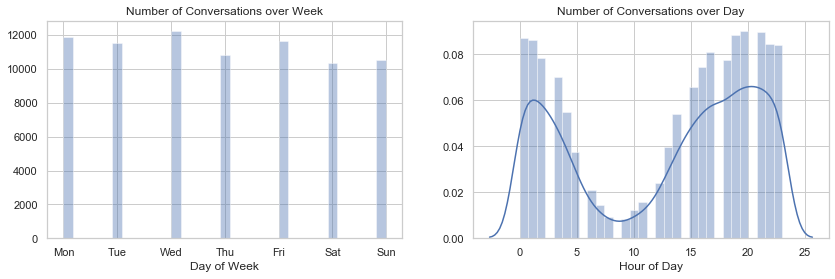

In [45]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
dplot = sns.distplot(convo.datetime.dt.weekday,
             kde=False)
plt.title('Number of Conversations over Week')
plt.xlabel('Day of Week')
dplot.set_xticks(list(range(7)))
dplot.set_xticklabels(['Mon', 'Tue', 'Wed',
                       'Thu', 'Fri', 'Sat', 'Sun'])
plt.subplot(122)
sns.distplot(convo.datetime.dt.hour)
plt.title('Number of Conversations over Day')
plt.xlabel('Hour of Day')
plt.show()

Here we're seeing slight increases that correlate with those party days, on Wedneday and Friday. We also see that conversations don't really begin to pick up until after noon, potentially indicating that before that students tend to be silent in class, asleep, preparing for class, or studying.

## 3.1 Comment on Generating Clusters with K-Means

In other notebooks I created clusters with conversation data, but I am choosing not to do that here because of the difficulty of interpreted such clusters. I would again be running K-Means in a two-dimensional space, and since I don't have location data for the conversations, there's no real way to pinpoint that students are having conversations in vicinity of each other. As I show below, it's not possible to easily engineer in location data from the gps dataset (the sensing data doesn't seem to all register at once in that way). With some complex engineering it could be possible to take the average of the latitude and longitude coordinates from the time just before and just after each conversation, but this seems to introuduce a great deal of noise and may not still create features that are very interpretable.

In [46]:
# Creating gps copy to change column names on
gps_merge = gps.copy()

gps_merge.columns = ['uid', 'start_timestamp', 'longitude', 'latitude']
merged = convo.merge(gps_merge[['uid', 'start_timestamp', 'latitude', 'longitude']],
            on=['uid', 'start_timestamp'],
            how='left')

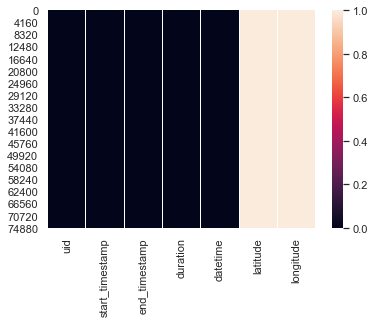

In [47]:
sns.heatmap(merged.isnull())

## 3.2 Creating Aggregates

Now I'll add this conversation proximity data to `sensing`, aggregating by student.

In [88]:
# Just doing a raw count of conversation observations per student
sensing['convo_num'] = sensing.uid.apply(
    lambda uid: len(convo[convo.uid==uid])
)

# Averaging the length of these conversations per student
sensing['convo_duration'] = sensing.uid.apply(
    lambda uid:
        convo.loc[
            convo.uid==uid,
            'duration'
        ].mean()
)

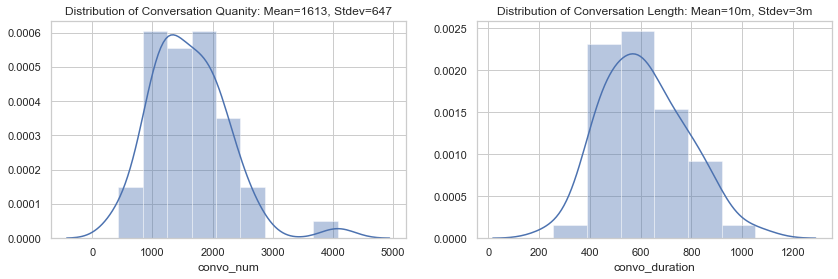

In [89]:
# Creating visualizations of distributions of new features
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(sensing.convo_num)
plt.title('Distribution of Conversation Quanity: Mean={}, Stdev={}'
          .format(round(sensing.convo_num.mean()),
                  round(sensing.convo_num.std()))
         )
plt.subplot(122)
sns.distplot(sensing.convo_duration)
plt.title('Distribution of Conversation Length: Mean={}m, Stdev={}m'
          .format(round(sensing.convo_duration.mean()/60),
                  round(sensing.convo_duration.std()/60))
         )
plt.show()

I can also imagine that the trend in how much student is having conversations or how long those conversations are over the course of a semester could be important. Below I add two more features to `sensing` representing the slope of the line of best fit for the number of conversations per day or the average length of conversation per day.

In [98]:
def get_slope(uid, var):
    
    days = list(convo[convo.uid==uid].datetime.dt.dayofyear.unique())

    if var=='length':
        y = [convo.loc[(convo.datetime.dt.dayofyear==day)&
                                      (convo.uid==uid),
                                      'duration'
                            ].mean()
                    for day in days]
    if var=='num':
        y = [len(convo.loc[(convo.datetime.dt.dayofyear==day)&
                                     (convo.uid==uid)])
                      for day in days]

    m, b = np.polyfit(days, y, 1)

#     sns.lineplot(
#         x=days,
#         y=y
#     )
#     plt.plot(days, m*days + b)
#     plt.title('Conversation Duration for {}'
#               .format(uid))
#     plt.show()

    return m

In [99]:
%%time
duration_slopes = []
for uid in sensing.uid:
    m = get_slope(uid, 'length')
    duration_slopes.append(m)
sensing['duration_slope'] = duration_slopes

CPU times: user 20.5 s, sys: 1.11 s, total: 21.6 s
Wall time: 20.5 s


In [100]:
%%time
num_slopes = []
for uid in sensing.uid:
    m = get_slope(uid, 'num')
    num_slopes.append(m)
sensing['num_slope'] = num_slopes

CPU times: user 21.6 s, sys: 1.15 s, total: 22.7 s
Wall time: 22.1 s


I'm guessing that I'm getting this error because there's some discreptancy between the days on which there are observations for a particular student and for the dataframe as a whole. I've tried to deal with this by slicing appropriately, but an error seems to have slipped through. At this point, though the function seems to be able to create the new features, so we'll leave this for now.

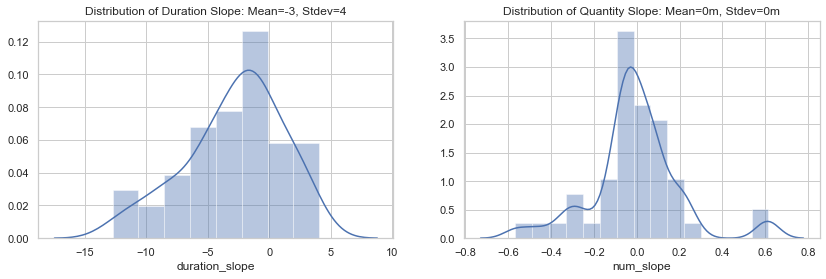

In [75]:
# Creating visualizations of distributions of new features
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(sensing.duration_slope)
plt.title('Distribution of Duration Slope: Mean={}, Stdev={}'
          .format(round(sensing.duration_slope.mean()),
                  round(sensing.duration_slope.std()))
         )
plt.subplot(122)
sns.distplot(sensing.num_slope)
plt.title('Distribution of Quantity Slope: Mean={}m, Stdev={}m'
          .format(round(sensing.num_slope.mean()/60),
                  round(sensing.num_slope.std()/60))
         )
plt.show()

# 4. Light

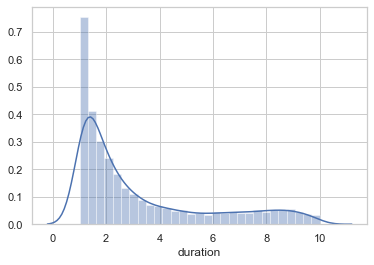

In [107]:
dark['duration'] = (dark.end - dark.start) / 3600 # dividing to convert to hours
sns.distplot(dark.duration)

In [108]:
dark['datetime'] = pd.to_datetime(dark.start, unit='s')

In [109]:
days = dark.datetime.dt.dayofyear.unique()

dark_per_day = [dark.loc[
    dark.datetime.dt.dayofyear==day,
    'duration'
    # diving by nunique to get h per student
].sum() / dark.uid.nunique() for day in days] 

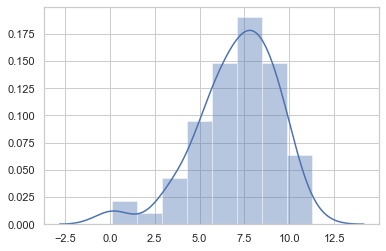

In [110]:
sns.distplot(dark_per_day)

That's interesting; time in the dark averages to about how much people sleep per night. Realistically they're probably sleeping somewhat less than 8 hours a night and other dark time is made up of walking in the dark, being in other dark environments, etc. But this seems like a reasonably good approximation for sleep on the largest level. In a return for a deeper analysis it would be interesting to compare this data with the EMA and survey response data on sleep on a per-student basis.

In [111]:
sensing['dark'] = sensing.uid.apply(
    lambda uid:
    dark.loc[
        dark.uid==uid,
        'duration'
    ].sum() / (dark.datetime.dt.dayofyear.max() -
               dark.datetime.dt.dayofyear.min())
)

Text(0.5, 1.0, 'Distribution of Average Daily Dark Time: std=3.03')

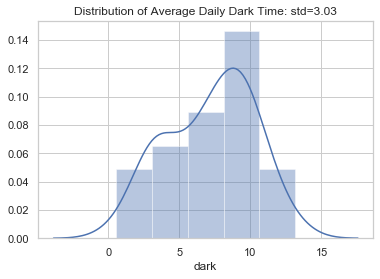

In [112]:
sns.distplot(sensing.dark)
plt.title('Distribution of Average Daily Dark Time: std={}'.
          format(round(sensing.dark.std(),2)))

Taking a first look at the results of the aggregation, it looks like this data could be pretty noisy. People might sleep in brighter than normal environments, or there could be another reason for the variation. It's a little bit of a black box, but not totally. We know at the least, for example, that if they're in a dark space for less than eight hours, they're either not sleeping or not sleeping in an environment that's totally suitable for sleeping.

# 5. Locked Phone

This part of the sensing data is interesting — it represents whenever the phone is locked and therefore not being used. We may be able to determine a correlation between not using the phone in general or in certain periods, and academic performance or mental health.

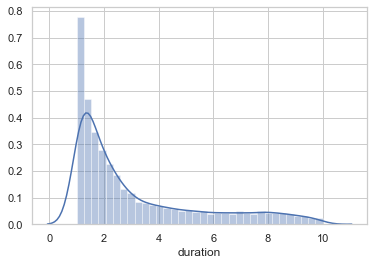

In [113]:
# Creating duration feature
lock.loc[:, 'duration'] = (lock.loc[:, 'end'] -
                           lock.loc[:, 'start']
                           ) / 3600 # dividing to convert to hours

# Datetime pinned to start time
lock.loc[:, 'datetime'] = pd.to_datetime(lock.start, unit='s')

# Visualizing duration
sns.distplot(lock.duration)

Seeing that many of the periods of the phones being locked are more than six hours, this data could be a good approximation of sleep, as well. What I'm more interested in the periods that the phone is locked during the day, indicating non-use during waking hours. Let's look at the distribution over hours in the day.

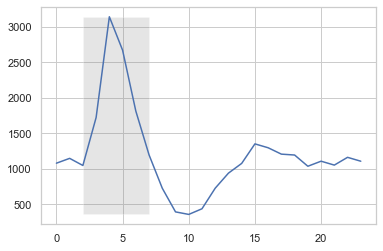

In [114]:
hours = lock.datetime.dt.hour.unique()
duration_by_hour = [lock.loc[lock.datetime.dt.hour==hour,
                             'duration'].sum()
                    for hour in hours]
lplot = sns.lineplot(
    x=hours,
    y=duration_by_hour
)
lplot.fill_between(
    [2,7],
    pd.Series(duration_by_hour).min(),
    pd.Series(duration_by_hour).max(),
    facecolor='grey',
    alpha=0.2)

There's a pretty sharp peak around 4am, and then a low dip from 8am to 11am, which is interesting. Let's check out the distribution during waking hours, which we'll define as everything outside the 'peak' here, shown shaded in — from 2am to 8am.

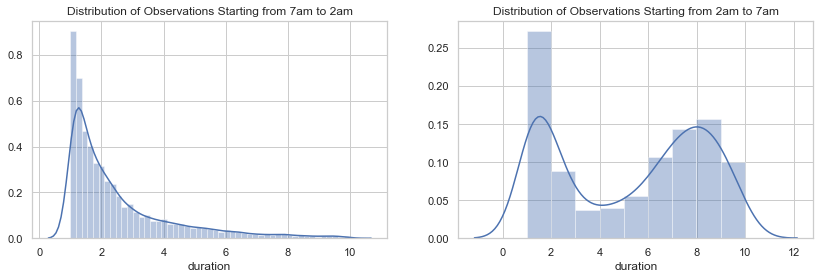

In [93]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(lock.loc[(lock.datetime.dt.hour<2)|
                      (lock.datetime.dt.hour>7),
                      'duration'])
plt.title('Distribution of Observations Starting from 7am to 2am')
plt.subplot(122)
sns.distplot(lock.loc[(lock.datetime.dt.hour>2)&
                      (lock.datetime.dt.hour<7),
                      'duration'])
plt.title('Distribution of Observations Starting from 2am to 7am')
plt.show()

My suspicion is confirmed that there are many more short lock periods during the day, and periods between 2am and 7am are often much longer.

What student-wise features should we create? The most intuitave one would just be total locked time starting between 7am and 2am. Another would be how many times the phone is locked, although I'm not sure this clearly signifies anything. The average locked period, however, could capture a little more of what the number of locks is trying to get at, which is how long the phone is locked compared to how many times it's locked and unlocked.

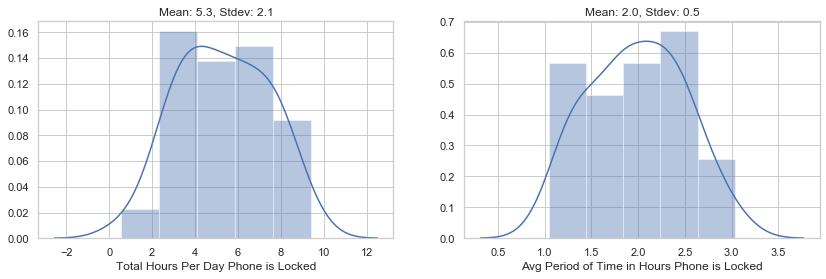

In [115]:
sensing['total_locked'] = sensing.uid.apply(
    lambda uid:
    lock.loc[
        (lock.uid==uid)&
        ((lock.datetime.dt.hour>7)|
         (lock.datetime.dt.hour<2)),
        'duration'
    ].sum()
)

sensing['avg_locked'] = sensing.uid.apply(
    lambda uid:
    lock.loc[
        (lock.uid==uid)&
        ((lock.datetime.dt.hour>7)|
         (lock.datetime.dt.hour<2)),
        'duration'
    ].sum() / len(lock.loc[lock.uid==uid])
)

study_length = lock.datetime.dt.dayofyear.max() - lock.datetime.dt.dayofyear.min()

plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(sensing.total_locked / study_length)
plt.title('Mean: {}, Stdev: {}'
          .format(round((sensing.total_locked / study_length).mean(), 1),
                  round((sensing.total_locked / study_length).std(), 1))
         )
plt.xlabel('Total Hours Per Day Phone is Locked')
plt.subplot(122)
sns.distplot(sensing.avg_locked)
plt.title('Mean: {}, Stdev: {}'
          .format(round((sensing.avg_locked).mean(), 1),
                  round((sensing.avg_locked).std(), 1))
         )
plt.xlabel('Avg Period of Time in Hours Phone is Locked')
plt.show()

# 6. Exploring Aggregated Sensing Data

In [116]:
# Dropping redundant columns
sensing = sensing.drop(columns=[np.nan])

KeyError: '[nan] not found in axis'

In [117]:
sensing[['convo_num', 'convo_duration', 'num_slope',
         'duration_slope', 'dark',
       'total_locked', 'avg_locked']].corr()

convo_num  convo_duration  num_slope  duration_slope  \
convo_num        1.000000       -0.014893   0.318955        0.176678   
convo_duration  -0.014893        1.000000  -0.102111       -0.144121   
num_slope        0.318955       -0.102111   1.000000       -0.036285   
duration_slope   0.176678       -0.144121  -0.036285        1.000000   
dark             0.514383        0.243359  -0.000016        0.026242   
total_locked     0.319404        0.140952  -0.028128        0.091878   
avg_locked      -0.402331       -0.039612  -0.301605       -0.174886   

                    dark  total_locked  avg_locked  
convo_num       0.514383      0.319404   -0.402331  
convo_duration  0.243359      0.140952   -0.039612  
num_slope      -0.000016     -0.028128   -0.301605  
duration_slope  0.026242      0.091878   -0.174886  
dark            1.000000      0.682251   -0.383582  
total_locked    0.682251      1.000000   -0.003840  
avg_locked     -0.383582     -0.003840    1.000000

#### **Return and correct given corrected slope values**

Notable correlations:
* The total amount of time phones are locked correlates with time in the dark, but that's tautological (the phone will be locked typically when in the dark, e.g., at night).
* On the other hand, time in the dark correlates with the number of conversations, which is interesting, and correlates a little with conversation duration as well. However, it doesn't correlate so much that autocorrelation will be an issue if we want to use these as variables in OLS.
* The slope of average conversation duration correlates with dark 13% more than duration does alone. This means in terms of determining how much a student sleeps (or spends in the dark), the increasing or decreasing trajectory of the students convserational patterns is more correlative than the average for the semester as a whole. This is not true, however, for how much the phone is locked.
* While the total number of conversations correlates negatively with the average amount of time a phone is locked (which makes sense), the trajectory of the number of conversations rising or falling over the course of the semseter correlates slightly positively. Maybe this is just to say, the total number matters, but it doesn't matter that much whether it increases or decreases.
* Similarly (and conversely), the number of conversations correlates *positively* with the total amount of time the phone is locked. I have more trouble making sense of this one, but I can create a scatterplot below to make sure. At the same time, the trajectory of the number of conversations correlates negatively with the total amount of time the phone is locked — if the number increases over time, it's more likely the phone will be locked less, and vice versa.

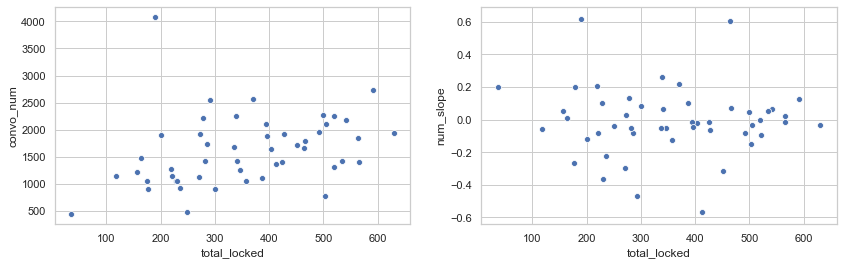

In [118]:
# Visualizing Locked / Number of Conversation correlation
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.scatterplot(
    x=sensing.total_locked,
    y=sensing.convo_num
)
plt.subplot(122)
sns.scatterplot(
    x=sensing.loc[
        sensing.num_slope < 2.5, # Dealing with some outliers provisionally
        'total_locked'],
    y=sensing.loc[
        sensing.num_slope < 2.5,
        'num_slope']
)
plt.show()

The relationships look weak, but definitely there, especially in the case of number of conversations.

Now let's visualize some of these features with the lat-lon clusters. A pairplot will allow us to visually check the students who have a large number of observations in a given cluster and see if among those students there seems to be a correlation with one of the other sensing features, without needing to go through and limit off the larger group of students for each cluster who have a very small number of observations there.

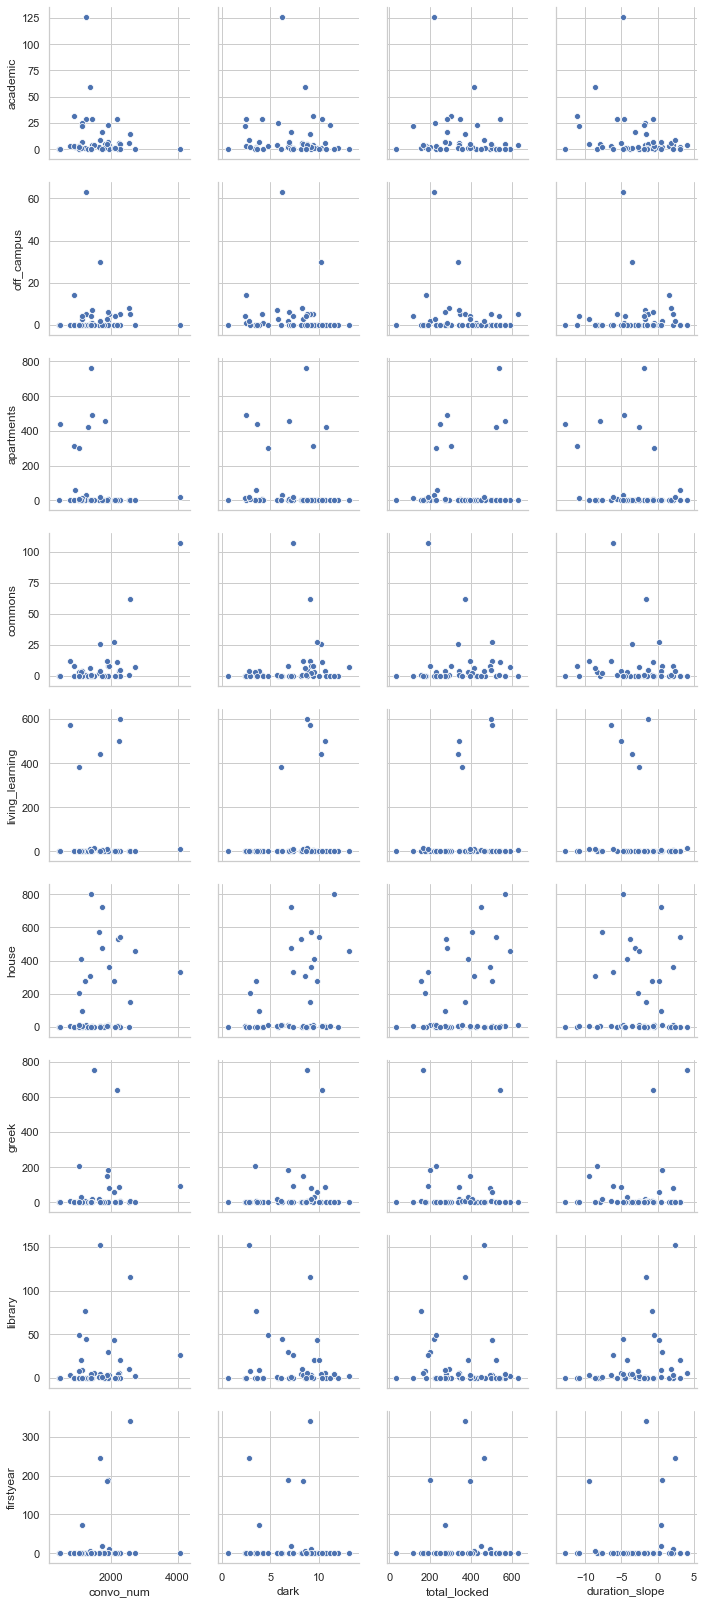

In [66]:
sns.pairplot(
    data=sensing,
    x_vars=['convo_num', 'dark', 'total_locked', 'duration_slope'],
    y_vars=['academic', 'off_campus', 'apartments', 'commons',
       'living_learning', 'house', 'greek', 'library', 'firstyear']
)

In all cases other than with `house`, we don't quite have enough observations to be able to identify a correlation clearly, though there seems to be some correlation with `firstyear` and between `apartments` and `total_locked` potentially, or between `library` and `dark`. This is a real case of simply needing more data.

With `house`, however, there seems to be a significant positive correlation between how much they're in housing and how much their phones are locked or in the dark.

In [67]:
for var in ['convo_num', 'dark', 'total_locked', 'num_slope', 'duration_slope']:
    print(var, '\n',
          sensing[['academic', 'cs_dept', 'off_campus', 'apartments', 'commons',
                  'living_learning', 'house', 'greek', 'library', 'firstyear']
                 ].corrwith(sensing[var]).sort_values(ascending=False)
         ,'\n')

convo_num 
 commons            0.620542
house              0.266286
firstyear          0.194707
library            0.159553
cs_dept            0.140080
greek              0.124211
living_learning    0.016060
off_campus        -0.046771
academic          -0.111965
apartments        -0.221012
dtype: float64 

dark 
 house              0.321491
living_learning    0.212522
commons            0.161308
greek              0.157693
off_campus        -0.039981
firstyear         -0.046130
cs_dept           -0.048070
academic          -0.053836
apartments        -0.073721
library           -0.147791
dtype: float64 

total_locked 
 house              0.242470
living_learning    0.148424
apartments         0.130945
firstyear          0.018383
library           -0.044498
commons           -0.055576
greek             -0.067074
cs_dept           -0.136633
academic          -0.139311
off_campus        -0.161421
dtype: float64 

num_slope 
 commons            0.429679
library            0.406752
firstye

Most significant correlations:
* 62% between time in commons and number of conversations
* 43% and 41% between time in commons and library respectively and positive trend in number of conversations
* -39% between being in non-computer science academic dept. and conversations lengthening over the course of the semester
* 32% between being in residence house and being in the dark
* 28% & 25% between being in computer science dept and being in the library respectively, and the trend of length of conversations
* -26% & -23%  between being in senior apartments and academic buildings respectively, and the trend of the length of conversations
* 26% between being in residence house and number of conversations
* 24% between being in residence house and total amount of time phone is locked

In [119]:
primary_gb = sensing.groupby('primary').mean()
primary_gb = primary_gb[['convo_num',  'convo_duration', 'dark',
                         'duration_slope', 'num_slope',
                          'total_locked', 'avg_locked']]

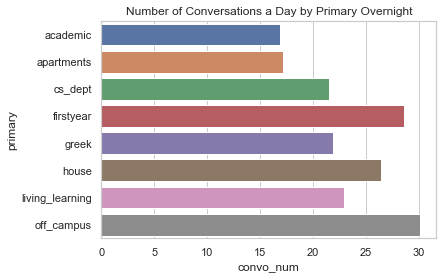

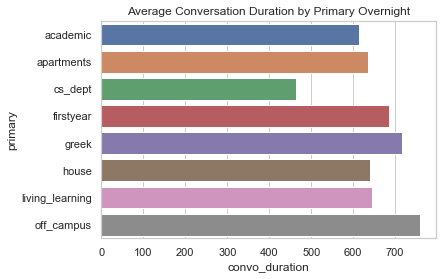

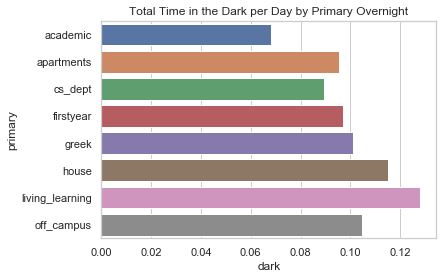

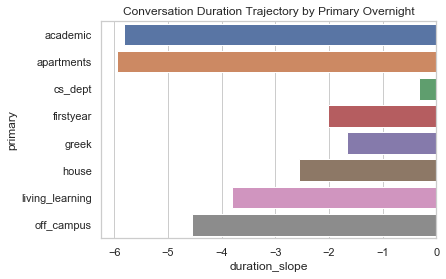

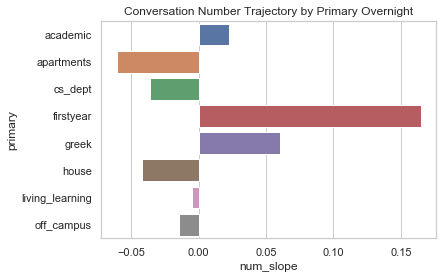

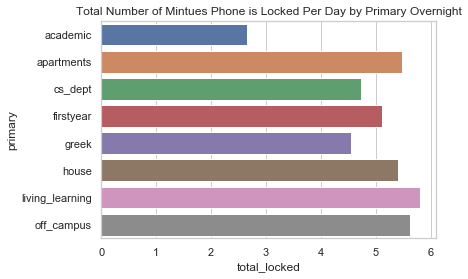

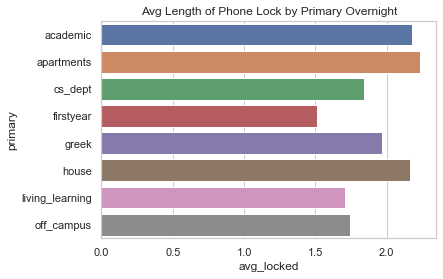

In [120]:
sns.barplot(
    y=primary_gb.index,
    x=primary_gb.convo_num / 70 # Dividing by ten weeks to get per day
)
plt.title('Number of Conversations a Day by Primary Overnight')
plt.show()

sns.barplot(
    y=primary_gb.index,
    x=primary_gb.convo_duration
)
plt.title('Average Conversation Duration by Primary Overnight')
plt.show()

sns.barplot(
    y=primary_gb.index,
    x=primary_gb.dark / 70 # Dividing by ten weeks to get per day
)
plt.title('Total Time in the Dark per Day by Primary Overnight')
plt.show()

sns.barplot(
    y=primary_gb.index,
    x=primary_gb.duration_slope
)
plt.title('Conversation Duration Trajectory by Primary Overnight')
plt.show()

sns.barplot(
    y=primary_gb.index,
    x=primary_gb.num_slope
)
plt.title('Conversation Number Trajectory by Primary Overnight')
plt.show()

sns.barplot(
    y=primary_gb.index,
    x=primary_gb.total_locked  / 70 # Dividing by ten weeks to get per day
)
plt.title('Total Number of Mintues Phone is Locked Per Day by Primary Overnight')
plt.show()

sns.barplot(
    y=primary_gb.index,
    x=primary_gb.avg_locked
)
plt.title('Avg Length of Phone Lock by Primary Overnight')
plt.show()

In [121]:
sns.barplot(
    y=primary_gb.index,
    x=primary_gb.gpa_13s
)
plt.title('Term GPA by Primary Overnight')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'gpa_13s'

# 7. Conclusions

With this analysis alone we have a fairly rich, and interpretable dataset! However, we want to move forward with using this data to describe and predict academic and mental health outcomes. In the next notebook I'll turn towards the academic and mental health data, and in the final notebook we'll bring the two together to develop predictive models.

In [70]:
# Downloading dataframe as CSV
sensing.to_csv('/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/sensing_final.csv', index=False)